In [1]:
import re
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier  
import seaborn as sb
from sklearn import tree
import pydotplus
import matplotlib as plt
from IPython.display import Image
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.interactive(False)
%matplotlib inline

C:\Users\yhoresh\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
sentence_1 = "For sale - Apples and Oranges"
sentence_2 = "Apple and Orange fruits for sale"


In [3]:
sentence_1 = sentence_1.lower()
sentence_2 = sentence_2.lower()

In [4]:
sentence_1, sentence_2

('for sale - apples and oranges', 'apple and orange fruits for sale')

In [5]:
sentence_1 = re.sub('\W+', '', sentence_1)
sentence_2 = re.sub('\W+', '', sentence_2)
sentence_1, sentence_2

('forsaleapplesandoranges', 'appleandorangefruitsforsale')

In [6]:
def get_3_tuples(x):
    return set(x[i:i+3] for i in range(len(x)-4))

In [7]:
sentence_1_tuples = get_3_tuples(sentence_1) 
sentence_1_tuples

{'ale',
 'and',
 'ang',
 'app',
 'dor',
 'eap',
 'esa',
 'for',
 'lea',
 'les',
 'ndo',
 'ora',
 'ors',
 'ple',
 'ppl',
 'ran',
 'rsa',
 'sal',
 'san'}

In [8]:
sentence_2_tuples = get_3_tuples(sentence_2) 
sentence_2_tuples

{'and',
 'ang',
 'app',
 'dor',
 'ean',
 'efr',
 'for',
 'fru',
 'gef',
 'its',
 'lea',
 'ndo',
 'nge',
 'ora',
 'ors',
 'ple',
 'ppl',
 'ran',
 'rsa',
 'rui',
 'sfo',
 'tsf',
 'uit'}

In [9]:
sent_intersection = sentence_1_tuples.intersection(sentence_2_tuples)
sent_intersection

{'and',
 'ang',
 'app',
 'dor',
 'for',
 'lea',
 'ndo',
 'ora',
 'ors',
 'ple',
 'ppl',
 'ran',
 'rsa'}

In [10]:
sent_union = sentence_1_tuples.union(sentence_2_tuples)
sent_union

{'ale',
 'and',
 'ang',
 'app',
 'dor',
 'ean',
 'eap',
 'efr',
 'esa',
 'for',
 'fru',
 'gef',
 'its',
 'lea',
 'les',
 'ndo',
 'nge',
 'ora',
 'ors',
 'ple',
 'ppl',
 'ran',
 'rsa',
 'rui',
 'sal',
 'san',
 'sfo',
 'tsf',
 'uit'}

In [11]:
len(sent_intersection) 

13

In [12]:
len(sent_union)

29

In [13]:
len(sent_intersection)  / len(sent_union)

0.4482758620689655

# A simple classifier

In [14]:
# load the titanic dataset
df = pd.read_csv(r'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

In [15]:
df.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
638,639,0,3,"Panula, Mrs. Juha (Maria Emilia Ojala)",female,41.00,0,5,3101295,39.6875,NaN,S
295,296,0,1,"Lewy, Mr. Ervin G",male,NaN,0,0,PC 17612,27.7208,NaN,C
587,588,1,1,"Frolicher-Stehli, Mr. Maxmillian",male,60.00,1,1,13567,79.2000,B41,C
502,503,0,3,"O'Sullivan, Miss. Bridget Mary",female,NaN,0,0,330909,7.6292,NaN,Q
185,186,0,1,"Rood, Mr. Hugh Roscoe",male,NaN,0,0,113767,50.0000,A32,S
555,556,0,1,"Wright, Mr. George",male,62.00,0,0,113807,26.5500,NaN,S
29,30,0,3,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,7.8958,NaN,S
398,399,0,2,"Pain, Dr. Alfred",male,23.00,0,0,244278,10.5000,NaN,S
644,645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,NaN,C
512,513,1,1,"McGough, Mr. James Robert",male,36.00,0,0,PC 17473,26.2875,E25,S


<AxesSubplot:>

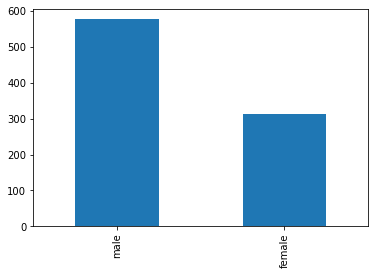

In [16]:
df.Sex.value_counts().plot(kind='bar')

C:\Users\yhoresh\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 15.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='Pclass', ylabel='Age'>

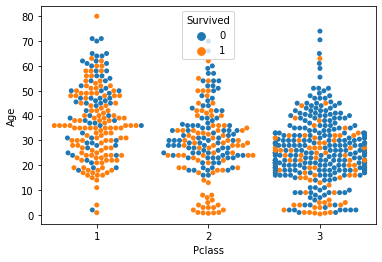

In [19]:
sb.swarmplot(x=df.Pclass, y=df.Age, hue=df.Survived)

C:\Users\yhoresh\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='Sex', ylabel='Age'>

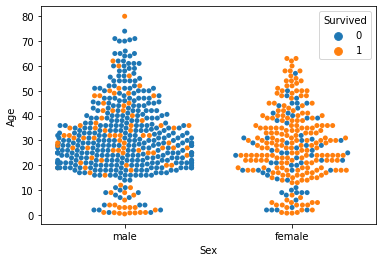

In [20]:
sb.swarmplot(x=df.Sex, y=df.Age, hue=df.Survived)

In [ ]:
def normalized_redacted_name(name):
    name = name.lower()
    name = re.sub('mr\.|miss\.|mrs\.', '', name)
    name = re.sub('\W+', '', name)
    return name

In [ ]:
%%time
df['norm_name'] = df['Name'].apply(normalized_redacted_name)
df['tuples'] = df['norm_name'].apply(get_3_tuples)

In [ ]:
df[['Name', 'norm_name','tuples']]

In [ ]:
%%time
list_of_tokens = []
for ind, row in df.iterrows():

    tuples = dict()
    for item in row.tuples:
        tuples[item] = 1
        
    tuples['index'] = ind
    tuples['gender'] = 1 if row.Sex=='female' else 0
    
    list_of_tokens.append(tuples)
    

In [ ]:
list_of_tokens[0:1]

In [ ]:
three_tuples_df = pd.DataFrame(list_of_tokens)
three_tuples_df.fillna(0, inplace=True)
three_tuples_df.sample(5)

In [ ]:
target_label = three_tuples_df.gender
three_tuples_df.drop('gender', axis=1, inplace=True)

In [ ]:
target_label.value_counts()

In [ ]:
# too many columns with a single value
list_of_columns_with_a_two_or_less_ones = sum(three_tuples_df.values) <= 2

In [ ]:
# remove columns with only a single value
three_tuples_df.drop(three_tuples_df.columns[list_of_columns_with_a_two_or_less_ones], axis=1, inplace=True)
three_tuples_df.sample(5)

In [ ]:
%%time

X_train, X_test, y_train, y_test = train_test_split(three_tuples_df, target_label, test_size=0.2, random_state=42)

In [ ]:
%%time
classifier = XGBClassifier( use_label_encoder=False) #class_weight='balanced',
model = classifier.fit(X_train, y_train)

prediction = model.predict(X_test)

print(classification_report(y_test, prediction))

confusion_matrix(y_test, prediction)


In [ ]:
#feature_importances
feature_imp = pd.DataFrame(data=list(zip(model.feature_importances_, X_test.columns)), columns=['imp', 'name'])
feature_imp.sort_values(by='imp', ascending=False, inplace=True)

sb.barplot(x=feature_imp.imp[0:10], y=feature_imp.name[0:10])


# A Decision Tree

In [ ]:
tree_classifier = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=3, min_samples_split=3)
tree_classifier.fit(X_train, y_train)

dot_data = tree.export_graphviz(tree_classifier, out_file=None, class_names=['male','female'], feature_names=X_test.columns, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_jpeg('dummy.jpeg')
Image(filename='dummy.jpeg', width=1000, height=1000)

prediction = tree_classifier.predict(X_test)


In [ ]:
print(classification_report(y_test, prediction))

confusion_matrix(y_test, prediction)